In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/kaggle.json 
! chmod 600 ~/.kaggle/kaggle.json 

In [4]:
! kaggle datasets download misrakahmed/vegetable-image-dataset

 99% 528M/534M [00:19<00:00, 24.5MB/s]
100% 534M/534M [00:19<00:00, 28.0MB/s]


In [ ]:
! unzip vegetable-image-dataset.zip

In [6]:
train_path = '/content/Vegetable Images/train'
validation_path = '/content/Vegetable Images/validation'
test_path = '/content/Vegetable Images/test'

In [8]:
import tensorflow as tf
import keras
from PIL import Image
import os
from pathlib import Path
import numpy as np

tf.__version__

'2.7.0'

In [10]:
train_dir = Path(train_path)
test_dir = Path(test_path)
validation_dir = Path(validation_path)

In [11]:
train_count = len(list(train_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))
validation_count = len(list(validation_dir.glob('*/*.jpg')))

In [12]:
train_count, test_count, validation_count 

(15000, 3000, 3000)

In [13]:
import matplotlib.pyplot as plt  
import seaborn as sns 

In [14]:
bean = list(train_dir.glob('Bean/*'))
img = Image.open(str(bean[0]))
width, height = img.size
width, height

(224, 224)

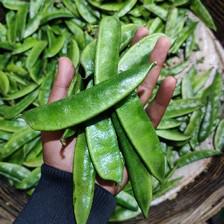

In [15]:
Image.open(bean[0])

In [16]:
batch_size, img_height, img_width = 32, height, width 

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 15000 files belonging to 15 classes.
Using 12000 files for training.


In [20]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3000 files belonging to 15 classes.
Using 600 files for validation.


In [21]:
class_name = train_ds.class_names
final=len(class_name)
final

15

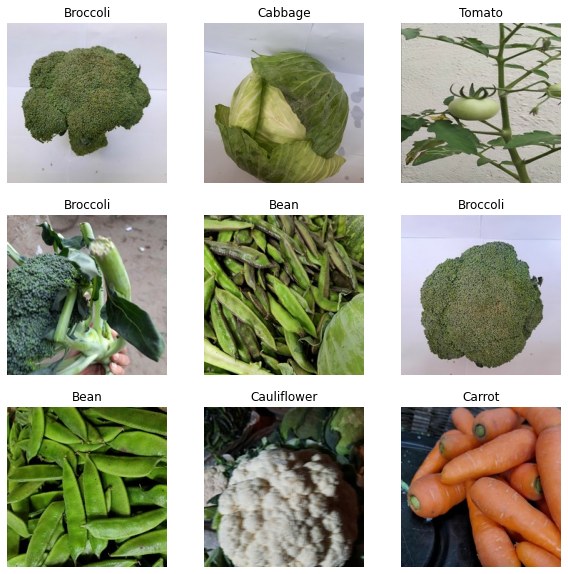

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis('off')

In [24]:
for i, l in train_ds:
  print(i.shape)
  print(l.shape)
  break

(32, 224, 224, 3)
(32,)


In [27]:
from keras.models import Sequential
from keras.layers import Input, Rescaling, Conv2D, MaxPool2D, Dropout, Flatten, Dense 

In [28]:
model = Sequential([
                    Input(shape=(img_height, img_width, 3)),

                    Rescaling(1./255),

                    Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPool2D(),

                    Dropout(0.2),

                    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPool2D(),

                    Dropout(0.2),

                    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPool2D(),

                    Dropout(0.5),

                    Flatten(),

                    Dense(128, activation='relu'),
                    Dense(final, activation='softmax')
])

In [29]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                    

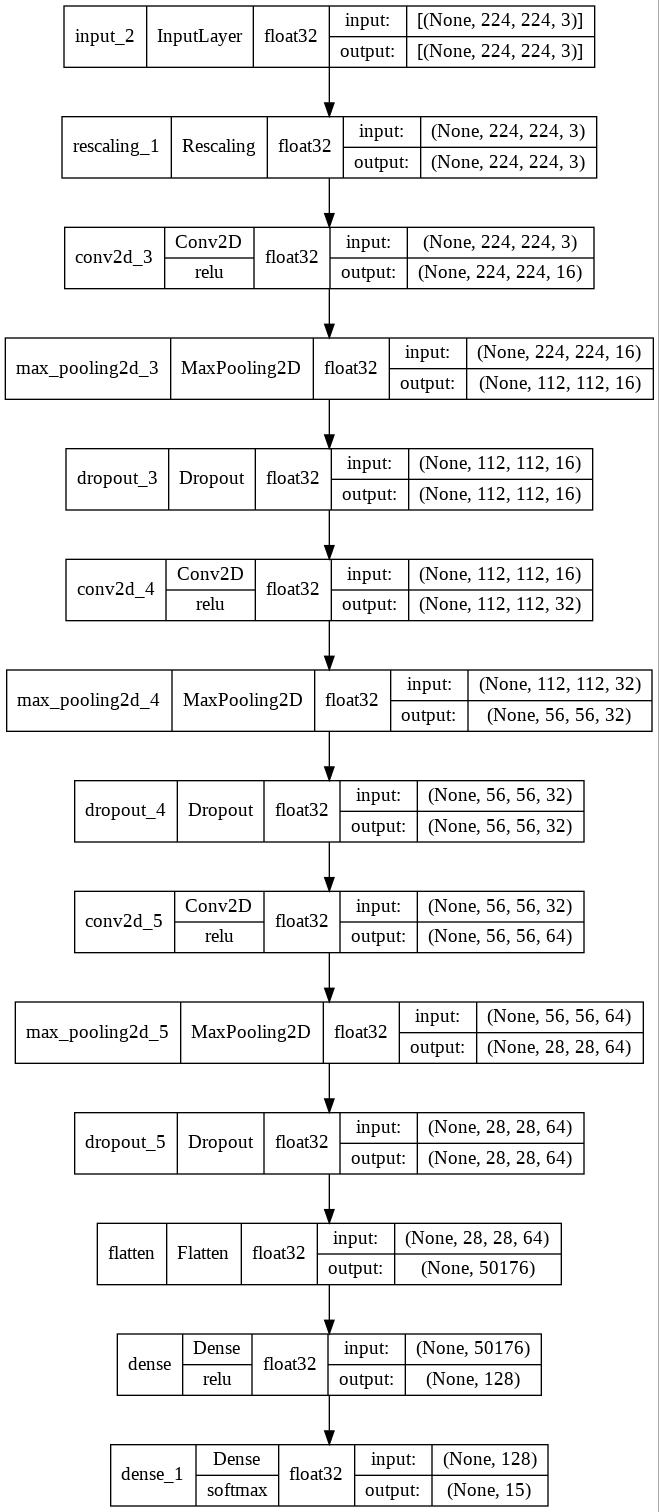

In [31]:
tf.keras.utils.plot_model(
    model,
    to_file='model.jpg',
    show_shapes=True, 
    show_dtype=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [32]:
early_stop = [
              keras.callbacks.EarlyStopping(
                  patience=2, 
                  monitor='val_loss',
                  restore_best_weights=True
              ),
              keras.callbacks.ModelCheckpoint(
                  'model.h5'
              ),
              keras.callbacks.TensorBoard(
                  log_dir='./logs'
              )
]

In [33]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=validation_ds,
    verbose=1,
    callbacks=early_stop
)

Epoch 1/20
375/375 [==============================] - 600s 2s/step - loss: 1.4324 - accuracy: 0.5317 - val_loss: 0.5725 - val_accuracy: 0.8150
Epoch 2/20
375/375 [==============================] - 594s 2s/step - loss: 0.4854 - accuracy: 0.8474 - val_loss: 0.3893 - val_accuracy: 0.8750
Epoch 3/20
375/375 [==============================] - 591s 2s/step - loss: 0.2578 - accuracy: 0.9212 - val_loss: 0.4151 - val_accuracy: 0.8650
Epoch 4/20
375/375 [==============================] - 588s 2s/step - loss: 0.1751 - accuracy: 0.9441 - val_loss: 0.2401 - val_accuracy: 0.9300
Epoch 5/20
375/375 [==============================] - 584s 2s/step - loss: 0.1215 - accuracy: 0.9619 - val_loss: 0.2510 - val_accuracy: 0.9200
Epoch 6/20
375/375 [==============================] - 588s 2s/step - loss: 0.0986 - accuracy: 0.9703 - val_loss: 0.3191 - val_accuracy: 0.9117


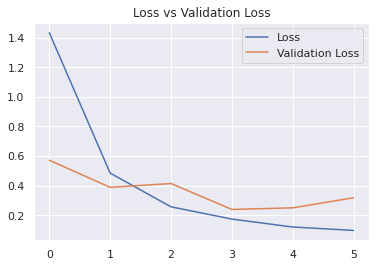

In [34]:
sns.set_theme()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss vs Validation Loss')
plt.show()

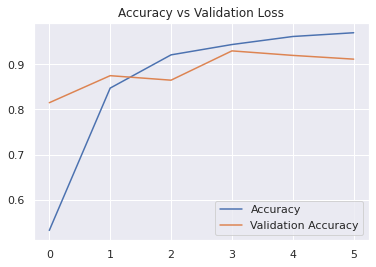

In [35]:
sns.set_theme()
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy vs Validation Loss')
plt.show()

In [36]:
model.save('model.h5')